In [21]:
import sys
from pathlib import Path
import matplotlib.pyplot as plt

# Agregar el directorio raíz del proyecto al path
root_dir = Path().resolve().parents[1]
if str(root_dir) not in sys.path:
    sys.path.append(str(root_dir))

import numpy as np
from src.utils.fonts_processor import load_fonts, get_char_labels
from src.models.components.optimizers import Adam

from src.models.components.mlp import MLP
from src.models.components.layers import Dense
from src.models.components.activation import Tanh, Sigmoid
from src.models.components.loss import bce, bce_prime

from src.models.components.noise import gaussian_noise, salt_and_pepper_noise

In [22]:
INPUT_DIM = 35    # 5 * 7 features
LATENT_DIM = 2
HIDDEN_DIM = 24
LEARNING_RATE = 0.001
EPOCHS = 9000
TRAIN_NOISE_LEVEL = 0.2
TEST_NOISE_LEVELS = [0.1, 0.15, 0.2, 0.3, 0.4]

# Cargar datos
X_train = load_fonts()
char_labels = get_char_labels()

In [24]:
# Análisis de arquitecturas para Denoising Autoencoders

# Configuración del análisis
ANALYSIS_EPOCHS = 3000  # Menos épocas para probar múltiples arquitecturas
ANALYSIS_NOISE_LEVEL = 0.2
LEARNING_RATE_ANALYSIS = 0.001
NUM_RUNS_PER_ARCHITECTURE = 3  # Número de veces que entrenamos cada arquitectura

# Definir arquitecturas a probar
# Formato: (nombre, hidden_layers_config)
# hidden_layers_config es una lista de tamaños de capas entre input y latent
architectures = [
    ("Shallow-16", [16]),           # 35 -> 16 -> 2 -> 16 -> 35
    ("Shallow-24", [24]),           # 35 -> 24 -> 2 -> 24 -> 35
    ("Deep-24-16", [24, 16]),       # 35 -> 24 -> 16 -> 2 -> 16 -> 24 -> 35
    ("Deep-32-16", [32, 16]),       # 35 -> 32 -> 16 -> 2 -> 16 -> 32 -> 35
    ("Deep-24-8", [24, 8]),       # 35 -> 40 -> 24 -> 2 -> 24 -> 40 -> 35
    ("VeryDeep-32-24-16", [32, 24, 16]),  # 35 -> 32 -> 24 -> 16 -> 2 -> 16 -> 24 -> 32 -> 35
]

def create_autoencoder_with_config(hidden_config):
    """
    Crea un autoencoder con la configuración de capas especificada.
    
    Args:
        hidden_config: Lista de tamaños de capas ocultas (encoder)
    
    Returns:
        Lista de capas para MLP
    """
    layers = []
    
    # Encoder
    prev_size = INPUT_DIM
    for hidden_size in hidden_config:
        layers.append(Dense(prev_size, hidden_size))
        layers.append(Tanh())
        prev_size = hidden_size
    
    # Bottleneck (latent space)
    layers.append(Dense(prev_size, LATENT_DIM))
    layers.append(Tanh())
    
    # Decoder (simétrico al encoder)
    prev_size = LATENT_DIM
    for hidden_size in reversed(hidden_config):
        layers.append(Dense(prev_size, hidden_size))
        layers.append(Tanh())
        prev_size = hidden_size
    
    # Output layer
    layers.append(Dense(prev_size, INPUT_DIM))
    layers.append(Sigmoid())
    
    return layers


def evaluate_denoising(model, X_test, noise_fn, noise_level):
    """
    Evalúa el rendimiento del denoising en datos de prueba.
    
    Returns:
        bce_score: Binary Cross-Entropy promedio
        pixel_error: Porcentaje de píxeles erróneos promedio (tras binarizar)
    """
    # Aplicar ruido y procesar cada muestra individualmente
    total_bce = 0
    total_pixel_error = 0
    
    for x in X_test:
        # Aplicar ruido
        x_noisy = noise_fn(x.copy(), noise_level)
        
        # Denoising
        x_denoised = model.forward(x_noisy.reshape(-1, 1)).flatten()
        
        # Calcular BCE para esta muestra
        total_bce += bce(x.reshape(-1, 1), x_denoised.reshape(-1, 1))
        
        # Calcular error de píxeles
        x_denoised_binary = (x_denoised > 0.5).astype(float)
        pixel_error = np.mean(x != x_denoised_binary)
        total_pixel_error += pixel_error
    
    # Promediar
    avg_bce = total_bce / len(X_test)
    avg_pixel_error = (total_pixel_error / len(X_test)) * 100
    
    return avg_bce, avg_pixel_error

# Entrenar y evaluar cada arquitectura con ambos tipos de ruido (múltiples runs)
# Estructura: results_gaussian[arch_name] = {'runs': [lista de diccionarios], 'config': ..., 'num_params': ...}
results_gaussian = {}
results_salt_pepper = {}

print("="*70)
print("ANÁLISIS DE ARQUITECTURAS PARA DENOISING AUTOENCODERS")
print(f"Runs por arquitectura: {NUM_RUNS_PER_ARCHITECTURE}")
print("="*70)

for arch_name, hidden_config in architectures:
    print(f"\n{'='*70}")
    print(f"Arquitectura: {arch_name}")
    print(f"Configuración: {INPUT_DIM} -> {' -> '.join(map(str, hidden_config))} -> {LATENT_DIM} -> {' -> '.join(map(str, reversed(hidden_config)))} -> {INPUT_DIM}")
    print(f"{'='*70}")
    
    # Inicializar estructuras para esta arquitectura
    results_gaussian[arch_name] = {'runs': [], 'config': hidden_config, 'num_params': 0}
    results_salt_pepper[arch_name] = {'runs': [], 'config': hidden_config, 'num_params': 0}
    
    # ===== RUIDO GAUSSIANO =====
    print(f"\n🔵 Entrenando con RUIDO GAUSSIANO ({NUM_RUNS_PER_ARCHITECTURE} runs)...")
    for run_idx in range(NUM_RUNS_PER_ARCHITECTURE):
        print(f"   Run {run_idx + 1}/{NUM_RUNS_PER_ARCHITECTURE}...", end=" ")
        
        layers_gaussian = create_autoencoder_with_config(hidden_config)
        model_gaussian = MLP(
            layers=layers_gaussian,
            loss=bce,
            loss_prime=bce_prime,
            optimizer=Adam(learning_rate=LEARNING_RATE_ANALYSIS)
        )
        
        history_gauss = model_gaussian.train_noise(
            X_train_clean=X_train,
            y_train_clean=X_train,
            epochs=ANALYSIS_EPOCHS,
            verbose=False,
            noise_level=ANALYSIS_NOISE_LEVEL,
            noise_fn=gaussian_noise
        )
        
        final_loss_gauss = history_gauss[-1]
        test_bce_gauss, pixel_error_gauss = evaluate_denoising(model_gaussian, X_train, gaussian_noise, ANALYSIS_NOISE_LEVEL)
        
        results_gaussian[arch_name]['runs'].append({
            'final_loss': final_loss_gauss,
            'test_bce': test_bce_gauss,
            'pixel_error': pixel_error_gauss
        })
        
        if run_idx == 0:
            results_gaussian[arch_name]['num_params'] = sum(layer.weights.size + layer.bias.size for layer in layers_gaussian if isinstance(layer, Dense))
        
        print(f"BCE: {test_bce_gauss:.6f}, Pixel Error: {pixel_error_gauss:.2f}%")
    
    # ===== RUIDO SALT & PEPPER =====
    print(f"\n🔴 Entrenando con RUIDO SALT & PEPPER ({NUM_RUNS_PER_ARCHITECTURE} runs)...")
    for run_idx in range(NUM_RUNS_PER_ARCHITECTURE):
        print(f"   Run {run_idx + 1}/{NUM_RUNS_PER_ARCHITECTURE}...", end=" ")
        
        layers_sp = create_autoencoder_with_config(hidden_config)
        model_sp = MLP(
            layers=layers_sp,
            loss=bce,
            loss_prime=bce_prime,
            optimizer=Adam(learning_rate=LEARNING_RATE_ANALYSIS)
        )
        
        history_sp = model_sp.train_noise(
            X_train_clean=X_train,
            y_train_clean=X_train,
            epochs=ANALYSIS_EPOCHS,
            verbose=False,
            noise_level=ANALYSIS_NOISE_LEVEL,
            noise_fn=salt_and_pepper_noise
        )
        
        final_loss_sp = history_sp[-1]
        test_bce_sp, pixel_error_sp = evaluate_denoising(model_sp, X_train, salt_and_pepper_noise, ANALYSIS_NOISE_LEVEL)
        
        results_salt_pepper[arch_name]['runs'].append({
            'final_loss': final_loss_sp,
            'test_bce': test_bce_sp,
            'pixel_error': pixel_error_sp
        })
        
        if run_idx == 0:
            results_salt_pepper[arch_name]['num_params'] = sum(layer.weights.size + layer.bias.size for layer in layers_sp if isinstance(layer, Dense))
        
        print(f"BCE: {test_bce_sp:.6f}, Pixel Error: {pixel_error_sp:.2f}%")

print(f"\n{'='*70}")
print("ANÁLISIS COMPLETADO")
print(f"{'='*70}")

ANÁLISIS DE ARQUITECTURAS PARA DENOISING AUTOENCODERS
Runs por arquitectura: 3

Arquitectura: Shallow-16
Configuración: 35 -> 16 -> 2 -> 16 -> 35

🔵 Entrenando con RUIDO GAUSSIANO (3 runs)...
   Run 1/3... BCE: 0.291580, Pixel Error: 13.75%
   Run 2/3... BCE: 0.291580, Pixel Error: 13.75%
   Run 2/3... BCE: 0.132388, Pixel Error: 5.00%
   Run 3/3... BCE: 0.132388, Pixel Error: 5.00%
   Run 3/3... BCE: 0.137304, Pixel Error: 4.64%

🔴 Entrenando con RUIDO SALT & PEPPER (3 runs)...
   Run 1/3... BCE: 0.137304, Pixel Error: 4.64%

🔴 Entrenando con RUIDO SALT & PEPPER (3 runs)...
   Run 1/3... BCE: 0.262270, Pixel Error: 12.77%
   Run 2/3... BCE: 0.262270, Pixel Error: 12.77%
   Run 2/3... BCE: 0.201219, Pixel Error: 9.46%
   Run 3/3... BCE: 0.201219, Pixel Error: 9.46%
   Run 3/3... BCE: 0.221030, Pixel Error: 10.45%

Arquitectura: Shallow-24
Configuración: 35 -> 24 -> 2 -> 24 -> 35

🔵 Entrenando con RUIDO GAUSSIANO (3 runs)...
   Run 1/3... BCE: 0.221030, Pixel Error: 10.45%

Arquitectura

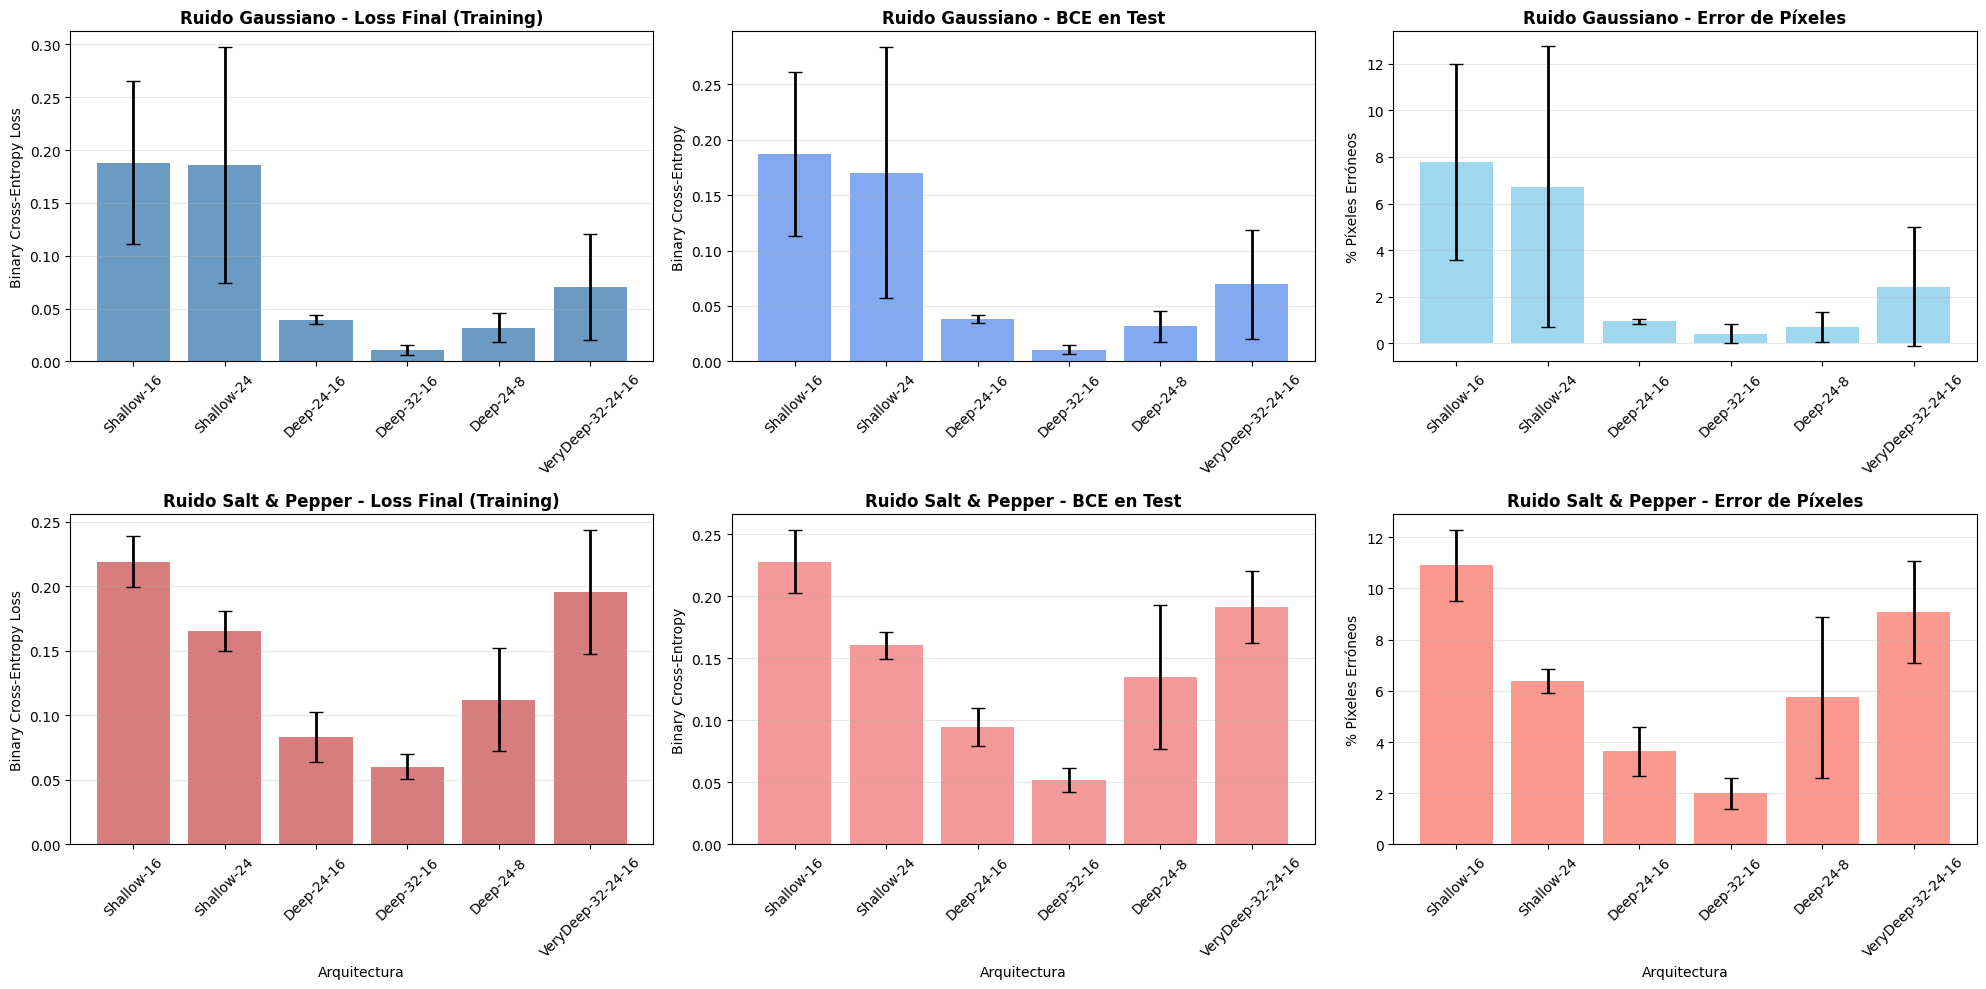


TABLA COMPARATIVA - RUIDO GAUSSIANO (Promedio ± Std de 3 runs)
Arquitectura              Parámetros      Loss Final                Test BCE                  Pixel Error (%)          
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Shallow-16                1253            0.187991 ± 0.077049       0.187091 ± 0.073912       7.80 ± 4.21              
Shallow-24                1861            0.186065 ± 0.111471       0.170144 ± 0.113215       6.73 ± 6.02              
Deep-24-16                2629            0.039626 ± 0.004338       0.038226 ± 0.003480       0.95 ± 0.11              
Deep-32-16                3461            0.010952 ± 0.004368       0.010787 ± 0.004219       0.42 ± 0.41              
Deep-24-8                 2197            0.032027 ± 0.013854       0.031642 ± 0.013679       0.71 ± 0.64              
VeryDeep-32-24-16         4789            0.070790 ± 0.

In [25]:
# Visualización de resultados del análisis con promedios y barras de error

fig, axes = plt.subplots(2, 3, figsize=(20, 10))

# Extraer datos para plotting
arch_names = list(results_gaussian.keys())

# Calcular promedios y desviaciones estándar para cada arquitectura
def compute_stats(results_dict, metric):
    """Calcula promedio y std para una métrica específica"""
    means = []
    stds = []
    for arch_name in arch_names:
        values = [run[metric] for run in results_dict[arch_name]['runs']]
        means.append(np.mean(values))
        stds.append(np.std(values))
    return means, stds

# ===== RUIDO GAUSSIANO =====
# Final Loss
loss_means_g, loss_stds_g = compute_stats(results_gaussian, 'final_loss')
axes[0, 0].bar(arch_names, loss_means_g, color='steelblue', alpha=0.8, yerr=loss_stds_g, capsize=5, error_kw={'linewidth': 2})
axes[0, 0].set_title('Ruido Gaussiano - Loss Final (Training)', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Binary Cross-Entropy Loss', fontsize=10)
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(axis='y', alpha=0.3)

# Test BCE
bce_means_g, bce_stds_g = compute_stats(results_gaussian, 'test_bce')
axes[0, 1].bar(arch_names, bce_means_g, color='cornflowerblue', alpha=0.8, yerr=bce_stds_g, capsize=5, error_kw={'linewidth': 2})
axes[0, 1].set_title('Ruido Gaussiano - BCE en Test', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Binary Cross-Entropy', fontsize=10)
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(axis='y', alpha=0.3)

# Pixel Error
pixel_means_g, pixel_stds_g = compute_stats(results_gaussian, 'pixel_error')
axes[0, 2].bar(arch_names, pixel_means_g, color='skyblue', alpha=0.8, yerr=pixel_stds_g, capsize=5, error_kw={'linewidth': 2})
axes[0, 2].set_title('Ruido Gaussiano - Error de Píxeles', fontsize=12, fontweight='bold')
axes[0, 2].set_ylabel('% Píxeles Erróneos', fontsize=10)
axes[0, 2].tick_params(axis='x', rotation=45)
axes[0, 2].grid(axis='y', alpha=0.3)

# ===== RUIDO SALT & PEPPER =====
# Final Loss
loss_means_sp, loss_stds_sp = compute_stats(results_salt_pepper, 'final_loss')
axes[1, 0].bar(arch_names, loss_means_sp, color='indianred', alpha=0.8, yerr=loss_stds_sp, capsize=5, error_kw={'linewidth': 2})
axes[1, 0].set_title('Ruido Salt & Pepper - Loss Final (Training)', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Binary Cross-Entropy Loss', fontsize=10)
axes[1, 0].set_xlabel('Arquitectura', fontsize=10)
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(axis='y', alpha=0.3)

# Test BCE
bce_means_sp, bce_stds_sp = compute_stats(results_salt_pepper, 'test_bce')
axes[1, 1].bar(arch_names, bce_means_sp, color='lightcoral', alpha=0.8, yerr=bce_stds_sp, capsize=5, error_kw={'linewidth': 2})
axes[1, 1].set_title('Ruido Salt & Pepper - BCE en Test', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Binary Cross-Entropy', fontsize=10)
axes[1, 1].set_xlabel('Arquitectura', fontsize=10)
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(axis='y', alpha=0.3)

# Pixel Error
pixel_means_sp, pixel_stds_sp = compute_stats(results_salt_pepper, 'pixel_error')
axes[1, 2].bar(arch_names, pixel_means_sp, color='salmon', alpha=0.8, yerr=pixel_stds_sp, capsize=5, error_kw={'linewidth': 2})
axes[1, 2].set_title('Ruido Salt & Pepper - Error de Píxeles', fontsize=12, fontweight='bold')
axes[1, 2].set_ylabel('% Píxeles Erróneos', fontsize=10)
axes[1, 2].set_xlabel('Arquitectura', fontsize=10)
axes[1, 2].tick_params(axis='x', rotation=45)
axes[1, 2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Tabla comparativa con promedios y desviaciones estándar
print("\n" + "="*160)
print(f"TABLA COMPARATIVA - RUIDO GAUSSIANO (Promedio ± Std de {NUM_RUNS_PER_ARCHITECTURE} runs)")
print("="*160)
print(f"{'Arquitectura':<25} {'Parámetros':<15} {'Loss Final':<25} {'Test BCE':<25} {'Pixel Error (%)':<25}")
print("-"*160)
for i, arch_name in enumerate(arch_names):
    num_params = results_gaussian[arch_name]['num_params']
    loss_str = f"{loss_means_g[i]:.6f} ± {loss_stds_g[i]:.6f}"
    bce_str = f"{bce_means_g[i]:.6f} ± {bce_stds_g[i]:.6f}"
    pixel_str = f"{pixel_means_g[i]:.2f} ± {pixel_stds_g[i]:.2f}"
    print(f"{arch_name:<25} {num_params:<15} {loss_str:<25} {bce_str:<25} {pixel_str:<25}")

print("\n" + "="*160)
print(f"TABLA COMPARATIVA - RUIDO SALT & PEPPER (Promedio ± Std de {NUM_RUNS_PER_ARCHITECTURE} runs)")
print("="*160)
print(f"{'Arquitectura':<25} {'Parámetros':<15} {'Loss Final':<25} {'Test BCE':<25} {'Pixel Error (%)':<25}")
print("-"*160)
for i, arch_name in enumerate(arch_names):
    num_params = results_salt_pepper[arch_name]['num_params']
    loss_str = f"{loss_means_sp[i]:.6f} ± {loss_stds_sp[i]:.6f}"
    bce_str = f"{bce_means_sp[i]:.6f} ± {bce_stds_sp[i]:.6f}"
    pixel_str = f"{pixel_means_sp[i]:.2f} ± {pixel_stds_sp[i]:.2f}"
    print(f"{arch_name:<25} {num_params:<15} {loss_str:<25} {bce_str:<25} {pixel_str:<25}")

# Identificar mejores arquitecturas por BCE (promedio)
best_gauss_bce_idx = np.argmin(bce_means_g)
best_sp_bce_idx = np.argmin(bce_means_sp)

# Identificar mejores arquitecturas por pixel error (promedio)
best_gauss_pixel_idx = np.argmin(pixel_means_g)
best_sp_pixel_idx = np.argmin(pixel_means_sp)

print("\n" + "="*160)
print("MEJORES ARQUITECTURAS (por BCE promedio)")
print("="*160)
print(f"🔵 Ruido Gaussiano: {arch_names[best_gauss_bce_idx]} (BCE: {bce_means_g[best_gauss_bce_idx]:.6f} ± {bce_stds_g[best_gauss_bce_idx]:.6f}, Pixel Error: {pixel_means_g[best_gauss_bce_idx]:.2f}% ± {pixel_stds_g[best_gauss_bce_idx]:.2f}%, Parámetros: {results_gaussian[arch_names[best_gauss_bce_idx]]['num_params']})")
print(f"🔴 Ruido Salt & Pepper: {arch_names[best_sp_bce_idx]} (BCE: {bce_means_sp[best_sp_bce_idx]:.6f} ± {bce_stds_sp[best_sp_bce_idx]:.6f}, Pixel Error: {pixel_means_sp[best_sp_bce_idx]:.2f}% ± {pixel_stds_sp[best_sp_bce_idx]:.2f}%, Parámetros: {results_salt_pepper[arch_names[best_sp_bce_idx]]['num_params']})")

print("\n" + "="*160)
print("MEJORES ARQUITECTURAS (por Pixel Error promedio)")
print("="*160)
print(f"🔵 Ruido Gaussiano: {arch_names[best_gauss_pixel_idx]} (Pixel Error: {pixel_means_g[best_gauss_pixel_idx]:.2f}% ± {pixel_stds_g[best_gauss_pixel_idx]:.2f}%, BCE: {bce_means_g[best_gauss_pixel_idx]:.6f} ± {bce_stds_g[best_gauss_pixel_idx]:.6f}, Parámetros: {results_gaussian[arch_names[best_gauss_pixel_idx]]['num_params']})")
print(f"🔴 Ruido Salt & Pepper: {arch_names[best_sp_pixel_idx]} (Pixel Error: {pixel_means_sp[best_sp_pixel_idx]:.2f}% ± {pixel_stds_sp[best_sp_pixel_idx]:.2f}%, BCE: {bce_means_sp[best_sp_pixel_idx]:.6f} ± {bce_stds_sp[best_sp_pixel_idx]:.6f}, Parámetros: {results_salt_pepper[arch_names[best_sp_pixel_idx]]['num_params']})")
print("="*160)

In [ ]:
# Usar la mejor arquitectura según el análisis
# Para ruido Gaussiano: Deep-32-16 suele ser mejor
# Para ruido Salt & Pepper: Deep-32-16 o Shallow-24 suelen ser mejores

# Crear autoencoder para ruido GAUSSIANO con capas independientes
mlp_dae_gaussian = MLP(
    layers=[
        Dense(INPUT_DIM, 32),
        Tanh(),
        Dense(32, 16),
        Tanh(),
        Dense(16, LATENT_DIM),
        Tanh(), 
        Dense(LATENT_DIM, 16),
        Tanh(),
        Dense(16, 32),
        Tanh(),
        Dense(32, INPUT_DIM),
        Sigmoid()
    ], 
    loss=bce, 
    loss_prime=bce_prime, 
    optimizer=Adam(learning_rate=LEARNING_RATE)
)

# Crear autoencoder para ruido SALT & PEPPER con capas independientes
mlp_dae_salt_pepper = MLP(
    layers=[
        Dense(INPUT_DIM, 32),
        Tanh(),
        Dense(32, 16),
        Tanh(),
        Dense(16, LATENT_DIM),
        Tanh(), 
        Dense(LATENT_DIM, 16),
        Tanh(),
        Dense(16, 32),
        Tanh(),
        Dense(32, INPUT_DIM),
        Sigmoid()
    ], 
    loss=bce, 
    loss_prime=bce_prime, 
    optimizer=Adam(learning_rate=LEARNING_RATE)
)

print("✅ Dos autoencoders creados:")
print("  - mlp_dae_gaussian: Para ruido gaussiano")
print("  - mlp_dae_salt_pepper: Para ruido salt & pepper")

✅ Dos autoencoders creados:
  - mlp_dae_gaussian: Para ruido gaussiano
  - mlp_dae_salt_pepper: Para ruido salt & pepper


In [ ]:
from src.models.components.noise import gaussian_noise, salt_and_pepper_noise

# Entrenar autoencoder con ruido gaussiano
print("Entrenando autoencoder con ruido GAUSSIANO...")
history_gaussian = mlp_dae_gaussian.train_noise(
    X_train_clean=X_train, 
    y_train_clean=X_train,
    epochs=EPOCHS, 
    verbose=True, 
    noise_level=TRAIN_NOISE_LEVEL,
    noise_fn=gaussian_noise
)
print("✅ Entrenamiento con ruido gaussiano completado!")

# Entrenar autoencoder con ruido salt & pepper
print("\nEntrenando autoencoder con ruido SALT & PEPPER...")
history_salt_pepper = mlp_dae_salt_pepper.train_noise(
    X_train_clean=X_train, 
    y_train_clean=X_train,
    epochs=EPOCHS, 
    verbose=True, 
    noise_level=TRAIN_NOISE_LEVEL,
    noise_fn=salt_and_pepper_noise
)
print("✅ Entrenamiento con ruido salt & pepper completado!")

Entrenando autoencoder con ruido GAUSSIANO...
Época 100/9000 - Pérdida (DAE): 0.502225
Época 200/9000 - Pérdida (DAE): 0.412633
Época 300/9000 - Pérdida (DAE): 0.340576
Época 400/9000 - Pérdida (DAE): 0.288442
Época 500/9000 - Pérdida (DAE): 0.239866
Época 600/9000 - Pérdida (DAE): 0.196875
Época 700/9000 - Pérdida (DAE): 0.157363
Época 800/9000 - Pérdida (DAE): 0.129072
Época 900/9000 - Pérdida (DAE): 0.105608
Época 1000/9000 - Pérdida (DAE): 0.092176
Época 1100/9000 - Pérdida (DAE): 0.077466
Época 1200/9000 - Pérdida (DAE): 0.067661
Época 1300/9000 - Pérdida (DAE): 0.070956
Época 1400/9000 - Pérdida (DAE): 0.055559
Época 1500/9000 - Pérdida (DAE): 0.049796
Época 1600/9000 - Pérdida (DAE): 0.045572
Época 1700/9000 - Pérdida (DAE): 0.047340
Época 1800/9000 - Pérdida (DAE): 0.040313
Época 1900/9000 - Pérdida (DAE): 0.035648
Época 2000/9000 - Pérdida (DAE): 0.033700
Época 2100/9000 - Pérdida (DAE): 0.027934
Época 2200/9000 - Pérdida (DAE): 0.024343
Época 2300/9000 - Pérdida (DAE): 0.0206

Generando visualización para ruido GAUSSIANO...


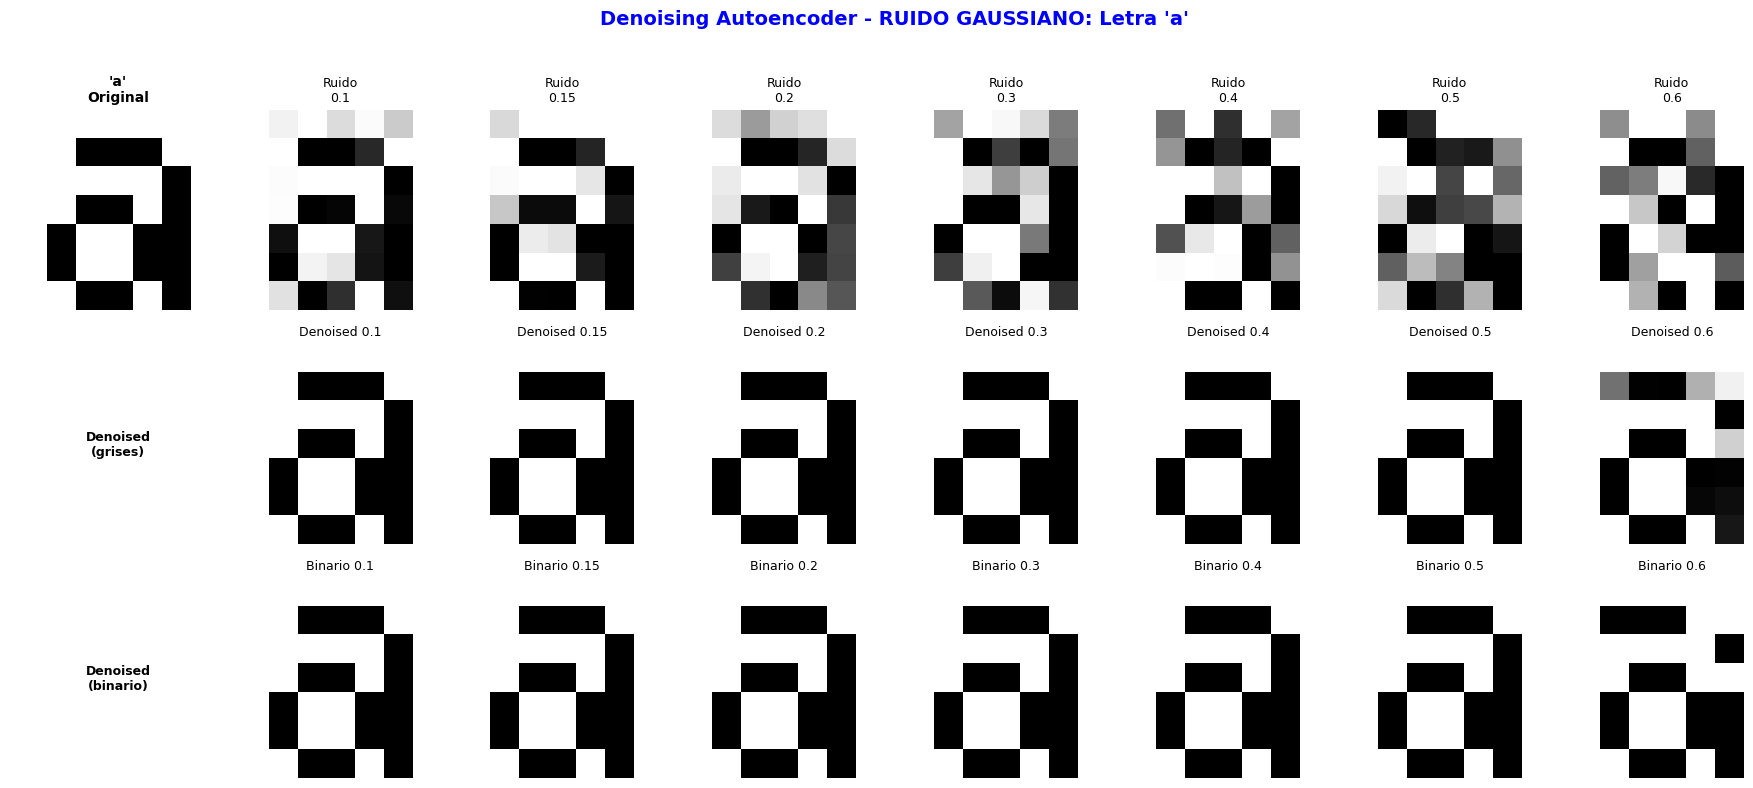

Generando visualización para ruido SALT & PEPPER...


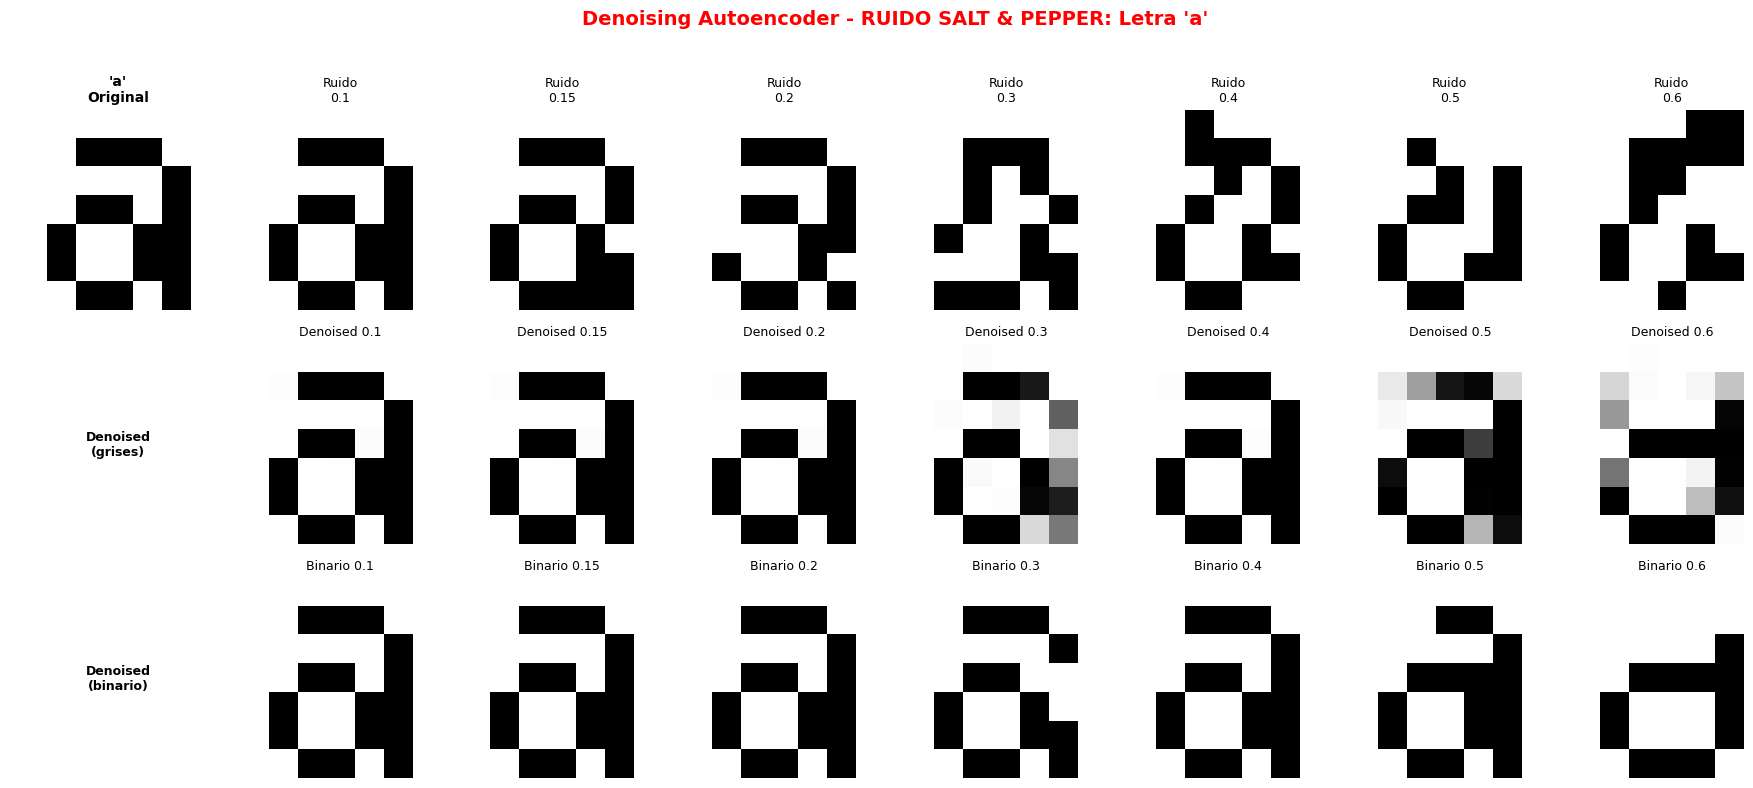


✅ Visualización de denoising completada para la letra 'a'
Niveles de ruido probados: [0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6]
Tipos de ruido: Gaussiano (gráfico 1) y Salt & Pepper (gráfico 2)


In [ ]:
import matplotlib.pyplot as plt
from src.models.components.noise import gaussian_noise, salt_and_pepper_noise

# Seleccionar la letra 'a' (índice 1)
char_idx = 1  # 'a'
char_original = X_train[char_idx]

# Generar versiones con diferentes niveles de ruido hasta 0.6
noise_levels = [0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6]

HEIGHT = 7
WIDTH = 5

# ========================================
# GRÁFICO 1: RUIDO GAUSSIANO
# ========================================
print("Generando visualización para ruido GAUSSIANO...")

# Ruido gaussiano
noisy_gaussian = [gaussian_noise(char_original.copy(), noise) for noise in noise_levels]

# Denoising usando el autoencoder gaussiano
denoised_gaussian = [mlp_dae_gaussian.forward(noisy.reshape(-1, 1)).flatten() for noisy in noisy_gaussian]

# Crear visualización para gaussiano (3 filas x 8 columnas)
fig1, axes1 = plt.subplots(3, 8, figsize=(18, 8))

# Fila 1: Original y ruido gaussiano
axes1[0, 0].imshow(char_original.reshape(HEIGHT, WIDTH), cmap='binary', interpolation='nearest')
axes1[0, 0].set_title(f"'{char_labels[char_idx]}'\nOriginal", fontweight='bold', fontsize=10)
axes1[0, 0].axis('off')

for i, (noisy, noise_level) in enumerate(zip(noisy_gaussian, noise_levels), 1):
    axes1[0, i].imshow(noisy.reshape(HEIGHT, WIDTH), cmap='gray_r', interpolation='nearest', vmin=0, vmax=1)
    axes1[0, i].set_title(f"Ruido\n{noise_level}", fontsize=9)
    axes1[0, i].axis('off')

# Fila 2: Denoised gaussiano (escala de grises)
axes1[1, 0].text(0.5, 0.5, 'Denoised\n(grises)', ha='center', va='center', fontsize=9, fontweight='bold')
axes1[1, 0].axis('off')

for i, (denoised, noise_level) in enumerate(zip(denoised_gaussian, noise_levels), 1):
    axes1[1, i].imshow(denoised.reshape(HEIGHT, WIDTH), cmap='gray_r', interpolation='nearest', vmin=0, vmax=1)
    axes1[1, i].set_title(f"Denoised {noise_level}", fontsize=9)
    axes1[1, i].axis('off')

# Fila 3: Denoised gaussiano (binarizado)
axes1[2, 0].text(0.5, 0.5, 'Denoised\n(binario)', ha='center', va='center', fontsize=9, fontweight='bold')
axes1[2, 0].axis('off')

for i, (denoised, noise_level) in enumerate(zip(denoised_gaussian, noise_levels), 1):
    denoised_binary = (denoised > 0.5).astype(float)
    axes1[2, i].imshow(denoised_binary.reshape(HEIGHT, WIDTH), cmap='binary', interpolation='nearest')
    axes1[2, i].set_title(f"Binario {noise_level}", fontsize=9)
    axes1[2, i].axis('off')

plt.suptitle(f"Denoising Autoencoder - RUIDO GAUSSIANO: Letra '{char_labels[char_idx]}'", 
             fontsize=14, fontweight='bold', color='blue')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# ========================================
# GRÁFICO 2: RUIDO SALT & PEPPER
# ========================================
print("Generando visualización para ruido SALT & PEPPER...")

# Ruido salt and pepper
noisy_salt_pepper = [salt_and_pepper_noise(char_original.copy(), noise) for noise in noise_levels]

# Denoising usando el autoencoder salt & pepper
denoised_salt_pepper = [mlp_dae_salt_pepper.forward(noisy.reshape(-1, 1)).flatten() for noisy in noisy_salt_pepper]

# Crear visualización para salt & pepper (3 filas x 8 columnas)
fig2, axes2 = plt.subplots(3, 8, figsize=(18, 8))

# Fila 1: Original y ruido salt & pepper
axes2[0, 0].imshow(char_original.reshape(HEIGHT, WIDTH), cmap='binary', interpolation='nearest')
axes2[0, 0].set_title(f"'{char_labels[char_idx]}'\nOriginal", fontweight='bold', fontsize=10)
axes2[0, 0].axis('off')

for i, (noisy, noise_level) in enumerate(zip(noisy_salt_pepper, noise_levels), 1):
    axes2[0, i].imshow(noisy.reshape(HEIGHT, WIDTH), cmap='binary', interpolation='nearest', vmin=0, vmax=1)
    axes2[0, i].set_title(f"Ruido\n{noise_level}", fontsize=9)
    axes2[0, i].axis('off')

# Fila 2: Denoised salt & pepper (escala de grises)
axes2[1, 0].text(0.5, 0.5, 'Denoised\n(grises)', ha='center', va='center', fontsize=9, fontweight='bold')
axes2[1, 0].axis('off')

for i, (denoised, noise_level) in enumerate(zip(denoised_salt_pepper, noise_levels), 1):
    axes2[1, i].imshow(denoised.reshape(HEIGHT, WIDTH), cmap='gray_r', interpolation='nearest', vmin=0, vmax=1)
    axes2[1, i].set_title(f"Denoised {noise_level}", fontsize=9)
    axes2[1, i].axis('off')

# Fila 3: Denoised salt & pepper (binarizado)
axes2[2, 0].text(0.5, 0.5, 'Denoised\n(binario)', ha='center', va='center', fontsize=9, fontweight='bold')
axes2[2, 0].axis('off')

for i, (denoised, noise_level) in enumerate(zip(denoised_salt_pepper, noise_levels), 1):
    denoised_binary = (denoised > 0.5).astype(float)
    axes2[2, i].imshow(denoised_binary.reshape(HEIGHT, WIDTH), cmap='binary', interpolation='nearest')
    axes2[2, i].set_title(f"Binario {noise_level}", fontsize=9)
    axes2[2, i].axis('off')

plt.suptitle(f"Denoising Autoencoder - RUIDO SALT & PEPPER: Letra '{char_labels[char_idx]}'", 
             fontsize=14, fontweight='bold', color='red')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

print(f"\n✅ Visualización de denoising completada para la letra '{char_labels[char_idx]}'")
print(f"Niveles de ruido probados: {noise_levels}")
print(f"Tipos de ruido: Gaussiano (gráfico 1) y Salt & Pepper (gráfico 2)")

Generando 10 versiones de ruido (nivel 0.2)...
Letra: 'a'
  ✓ Versión Gaussiana 1/10
  ✓ Versión Gaussiana 2/10
  ✓ Versión Gaussiana 3/10
  ✓ Versión Gaussiana 4/10
  ✓ Versión Gaussiana 5/10
  ✓ Versión Gaussiana 6/10
  ✓ Versión Gaussiana 7/10
  ✓ Versión Gaussiana 8/10
  ✓ Versión Gaussiana 9/10
  ✓ Versión Gaussiana 10/10
  ✓ Versión Salt & Pepper 1/10
  ✓ Versión Salt & Pepper 2/10
  ✓ Versión Salt & Pepper 3/10
  ✓ Versión Salt & Pepper 4/10
  ✓ Versión Salt & Pepper 5/10
  ✓ Versión Salt & Pepper 6/10
  ✓ Versión Salt & Pepper 7/10
  ✓ Versión Salt & Pepper 8/10
  ✓ Versión Salt & Pepper 9/10
  ✓ Versión Salt & Pepper 10/10

✅ Generadas 10 versiones por cada tipo. Creando GIF...
✅ GIF guardado en: c:\Users\juani\OneDrive\Documentos\itba\cuatrimestre-12\sia\SIA-TP5\results\ej2\noise_versions.gif


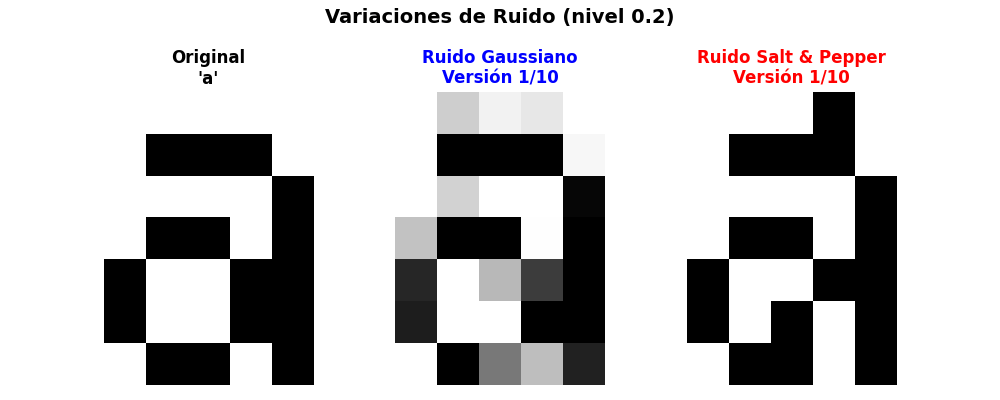

In [6]:
# GIF mostrando solo las variaciones de ruido (sin pasar por autoencoder)
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import Image

# Configuración
GIF_NOISE_LEVEL = 0.2
GIF_NUM_VERSIONS = 10
GIF_CHAR_IDX = 1  # Letra 'a'

# Preparar muestra original
char_original = X_train[GIF_CHAR_IDX]

print(f"Generando {GIF_NUM_VERSIONS} versiones de ruido (nivel {GIF_NOISE_LEVEL})...")
print(f"Letra: '{char_labels[GIF_CHAR_IDX]}'")

# Generar múltiples versiones de ruido gaussiano (solo el ruido)
gaussian_versions = []
for i in range(GIF_NUM_VERSIONS):
    noisy = gaussian_noise(char_original.copy(), GIF_NOISE_LEVEL)
    gaussian_versions.append(noisy)
    print(f"  ✓ Versión Gaussiana {i+1}/{GIF_NUM_VERSIONS}")

# Generar múltiples versiones de ruido salt & pepper (solo el ruido)
salt_pepper_versions = []
for i in range(GIF_NUM_VERSIONS):
    noisy = salt_and_pepper_noise(char_original.copy(), GIF_NOISE_LEVEL)
    salt_pepper_versions.append(noisy)
    print(f"  ✓ Versión Salt & Pepper {i+1}/{GIF_NUM_VERSIONS}")

print(f"\n✅ Generadas {GIF_NUM_VERSIONS} versiones por cada tipo. Creando GIF...")

# Crear animación
HEIGHT = 7
WIDTH = 5
fig, axes = plt.subplots(1, 3, figsize=(10, 4))

def update_frame(frame_idx):
    for ax in axes:
        ax.clear()
        ax.axis('off')
    
    # Original
    axes[0].imshow(char_original.reshape(HEIGHT, WIDTH), cmap='binary', interpolation='nearest')
    axes[0].set_title(f"Original\n'{char_labels[GIF_CHAR_IDX]}'", fontweight='bold', fontsize=12)
    
    # Ruido gaussiano
    axes[1].imshow(gaussian_versions[frame_idx].reshape(HEIGHT, WIDTH), 
                   cmap='gray_r', interpolation='nearest', vmin=0, vmax=1)
    axes[1].set_title(f"Ruido Gaussiano\nVersión {frame_idx+1}/{GIF_NUM_VERSIONS}", 
                      fontweight='bold', fontsize=12, color='blue')
    
    # Ruido salt & pepper
    axes[2].imshow(salt_pepper_versions[frame_idx].reshape(HEIGHT, WIDTH), 
                   cmap='binary', interpolation='nearest', vmin=0, vmax=1)
    axes[2].set_title(f"Ruido Salt & Pepper\nVersión {frame_idx+1}/{GIF_NUM_VERSIONS}", 
                      fontweight='bold', fontsize=12, color='red')
    
    plt.suptitle(f"Variaciones de Ruido (nivel {GIF_NOISE_LEVEL})", 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()

anim = FuncAnimation(fig, update_frame, frames=GIF_NUM_VERSIONS, interval=800, repeat=True)

# Guardar GIF
gif_path = r"c:\Users\juani\OneDrive\Documentos\itba\cuatrimestre-12\sia\SIA-TP5\results\ej2\noise_versions.gif"
writer = PillowWriter(fps=1.5)
anim.save(gif_path, writer=writer)

plt.close()

print(f"✅ GIF guardado en: {gif_path}")

# Mostrar el GIF
Image(filename=gif_path)

EVALUACIÓN DE ERROR DE PÍXELES - TODAS LAS LETRAS
Número de letras: 32
Número de runs por letra: 10
Niveles de ruido: [0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6]

Evaluando letra '`' (1/32)...

Evaluando letra 'a' (2/32)...

Evaluando letra 'b' (3/32)...

Evaluando letra 'c' (4/32)...

Evaluando letra 'd' (5/32)...

Evaluando letra 'e' (6/32)...

Evaluando letra 'b' (3/32)...

Evaluando letra 'c' (4/32)...

Evaluando letra 'd' (5/32)...

Evaluando letra 'e' (6/32)...

Evaluando letra 'f' (7/32)...

Evaluando letra 'g' (8/32)...

Evaluando letra 'h' (9/32)...

Evaluando letra 'i' (10/32)...

Evaluando letra 'j' (11/32)...

Evaluando letra 'k' (12/32)...

Evaluando letra 'f' (7/32)...

Evaluando letra 'g' (8/32)...

Evaluando letra 'h' (9/32)...

Evaluando letra 'i' (10/32)...

Evaluando letra 'j' (11/32)...

Evaluando letra 'k' (12/32)...

Evaluando letra 'l' (13/32)...

Evaluando letra 'm' (14/32)...

Evaluando letra 'n' (15/32)...

Evaluando letra 'o' (16/32)...

Evaluando letra 'p' (17/32).

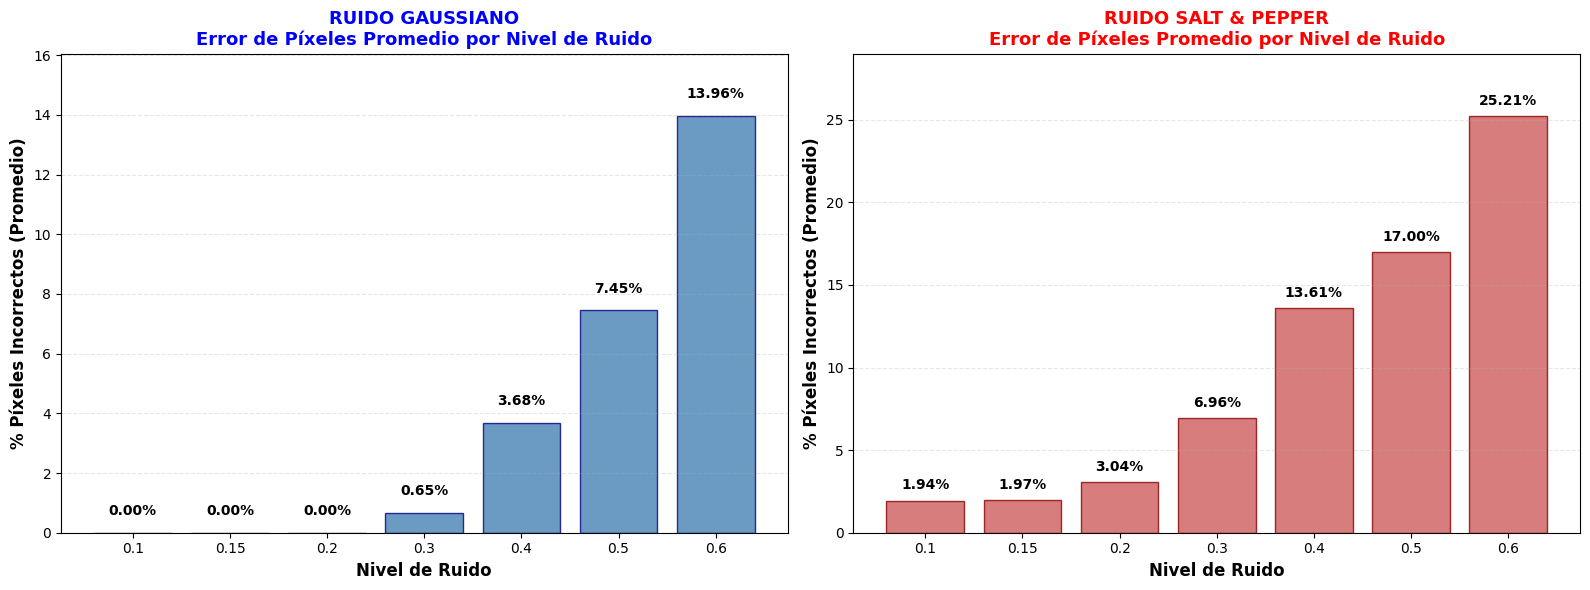


TABLA DE RESULTADOS - ERROR DE PÍXELES PROMEDIO
Nivel de Ruido       Gaussiano (%)             Salt & Pepper (%)        
----------------------------------------------------------------------------------------------------
0.1                  0.00                      1.94                     
0.15                 0.00                      1.97                     
0.2                  0.00                      3.04                     
0.3                  0.65                      6.96                     
0.4                  3.68                      13.61                    
0.5                  7.45                      17.00                    
0.6                  13.96                     25.21                    

Nota: Cada valor es el promedio de 10 runs sobre 32 letras diferentes.


In [16]:
# Evaluación completa: Error de píxeles promedio por nivel de ruido
import matplotlib.pyplot as plt
import numpy as np

# Configuración
NUM_RUNS = 10  # Número de veces que corremos cada letra con cada nivel de ruido
EVAL_NOISE_LEVELS = [0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6]

print("="*80)
print("EVALUACIÓN DE ERROR DE PÍXELES - TODAS LAS LETRAS")
print("="*80)
print(f"Número de letras: {len(X_train)}")
print(f"Número de runs por letra: {NUM_RUNS}")
print(f"Niveles de ruido: {EVAL_NOISE_LEVELS}")
print("="*80)

# Almacenar resultados
# pixel_errors[noise_type][noise_level] = lista de errores
pixel_errors_gaussian = {level: [] for level in EVAL_NOISE_LEVELS}
pixel_errors_salt_pepper = {level: [] for level in EVAL_NOISE_LEVELS}

# Evaluar cada letra, múltiples veces, con cada nivel de ruido
for char_idx, char in enumerate(X_train):
    char_label = char_labels[char_idx]
    print(f"\nEvaluando letra '{char_label}' ({char_idx+1}/{len(X_train)})...")
    
    for noise_level in EVAL_NOISE_LEVELS:
        # ===== RUIDO GAUSSIANO =====
        gaussian_pixel_errors = []
        for run in range(NUM_RUNS):
            # Aplicar ruido
            noisy = gaussian_noise(char.copy(), noise_level)
            
            # Denoising
            denoised = mlp_dae_gaussian.forward(noisy.reshape(-1, 1)).flatten()
            
            # Binarizar
            denoised_binary = (denoised > 0.5).astype(float)
            
            # Calcular error de píxeles
            pixel_error = np.mean(char != denoised_binary)
            gaussian_pixel_errors.append(pixel_error)
        
        # Guardar promedio de esta letra para este nivel de ruido
        avg_error = np.mean(gaussian_pixel_errors)
        pixel_errors_gaussian[noise_level].append(avg_error)
        
        # ===== RUIDO SALT & PEPPER =====
        sp_pixel_errors = []
        for run in range(NUM_RUNS):
            # Aplicar ruido
            noisy = salt_and_pepper_noise(char.copy(), noise_level)
            
            # Denoising
            denoised = mlp_dae_salt_pepper.forward(noisy.reshape(-1, 1)).flatten()
            
            # Binarizar
            denoised_binary = (denoised > 0.5).astype(float)
            
            # Calcular error de píxeles
            pixel_error = np.mean(char != denoised_binary)
            sp_pixel_errors.append(pixel_error)
        
        # Guardar promedio de esta letra para este nivel de ruido
        avg_error = np.mean(sp_pixel_errors)
        pixel_errors_salt_pepper[noise_level].append(avg_error)

print("\n" + "="*80)
print("✅ EVALUACIÓN COMPLETADA")
print("="*80)

# Calcular promedios finales (promedio sobre todas las letras)
avg_pixel_error_gaussian = [np.mean(pixel_errors_gaussian[level]) * 100 for level in EVAL_NOISE_LEVELS]
avg_pixel_error_salt_pepper = [np.mean(pixel_errors_salt_pepper[level]) * 100 for level in EVAL_NOISE_LEVELS]

# Crear gráfico de barras
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ===== GRÁFICO 1: RUIDO GAUSSIANO =====
x_pos = np.arange(len(EVAL_NOISE_LEVELS))
axes[0].bar(x_pos, avg_pixel_error_gaussian, color='steelblue', alpha=0.8, edgecolor='navy')
axes[0].set_xlabel('Nivel de Ruido', fontsize=12, fontweight='bold')
axes[0].set_ylabel('% Píxeles Incorrectos (Promedio)', fontsize=12, fontweight='bold')
axes[0].set_title('RUIDO GAUSSIANO\nError de Píxeles Promedio por Nivel de Ruido', 
                  fontsize=13, fontweight='bold', color='blue')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(EVAL_NOISE_LEVELS)
axes[0].grid(axis='y', alpha=0.3, linestyle='--')

# Agregar valores sobre las barras
for i, v in enumerate(avg_pixel_error_gaussian):
    axes[0].text(i, v + 0.5, f'{v:.2f}%', ha='center', va='bottom', 
                 fontweight='bold', fontsize=10)

# Ajustar límites del eje Y para que no se pisen los números
max_val_gauss = max(avg_pixel_error_gaussian)
axes[0].set_ylim(0, max_val_gauss * 1.15)

# ===== GRÁFICO 2: RUIDO SALT & PEPPER =====
axes[1].bar(x_pos, avg_pixel_error_salt_pepper, color='indianred', alpha=0.8, edgecolor='darkred')
axes[1].set_xlabel('Nivel de Ruido', fontsize=12, fontweight='bold')
axes[1].set_ylabel('% Píxeles Incorrectos (Promedio)', fontsize=12, fontweight='bold')
axes[1].set_title('RUIDO SALT & PEPPER\nError de Píxeles Promedio por Nivel de Ruido', 
                  fontsize=13, fontweight='bold', color='red')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(EVAL_NOISE_LEVELS)
axes[1].grid(axis='y', alpha=0.3, linestyle='--')

# Agregar valores sobre las barras
for i, v in enumerate(avg_pixel_error_salt_pepper):
    axes[1].text(i, v + 0.5, f'{v:.2f}%', ha='center', va='bottom', 
                 fontweight='bold', fontsize=10)

# Ajustar límites del eje Y para que no se pisen los números
max_val_sp = max(avg_pixel_error_salt_pepper)
axes[1].set_ylim(0, max_val_sp * 1.15)

plt.tight_layout()
plt.show()

# Tabla de resultados
print("\n" + "="*100)
print("TABLA DE RESULTADOS - ERROR DE PÍXELES PROMEDIO")
print("="*100)
print(f"{'Nivel de Ruido':<20} {'Gaussiano (%)':<25} {'Salt & Pepper (%)':<25}")
print("-"*100)
for i, level in enumerate(EVAL_NOISE_LEVELS):
    print(f"{level:<20} {avg_pixel_error_gaussian[i]:<25.2f} {avg_pixel_error_salt_pepper[i]:<25.2f}")
print("="*100)
print(f"\nNota: Cada valor es el promedio de {NUM_RUNS} runs sobre {len(X_train)} letras diferentes.")